## GPU

Enable GPU with `Runtime->Change runtime type->Hardware Accelerator->GPU` in the top menu

In [11]:
# imports and stuff
import time
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import rasterio
import gdal
import scipy
import cv2

from unet_bathy import *

import sys

from IPython.display import clear_output
import numpy.ma as ma
import torch.nn.functional as F
from torchvision.transforms import RandomCrop, Resize
from skimage.transform import resize, rotate, resize_local_mean
from sklearn.metrics import mean_squared_error
import scipy.ndimage 
import os

import cv2
from torchvision.transforms import Resize
from skimage.transform import resize as skimage_resize 

#print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
cv2                 4.5.5
gdal                NA
matplotlib          3.5.1
numpy               1.22.1
pandas              1.4.1
pkg_resources       NA
rasterio            1.3.9
scipy               1.8.0
sinfo               0.3.4
skimage             0.19.2
sklearn             1.0.2
torch               2.1.0+cu121
torchvision         0.16.0+cu121
tqdm                4.64.0
unet_bathy          NA
-----
IPython             8.3.0
jupyter_client      7.3.1
jupyter_core        4.10.0
jupyterlab          3.4.0
n

Backbone Names    Variants
----------------  ------------------------------------
ResNet            ['18', '34', '50', '101', '152']
ResNetD           ['18', '50', '101']
MicroNet          ['M1', 'M2', 'M3']
MobileNetV2       ['1.0']
MobileNetV3       ['S', 'L']
MiT               ['B0', 'B1', 'B2', 'B3', 'B4', 'B5']
PVTv2             ['B1', 'B2', 'B3', 'B4', 'B5']
ResT              ['S', 'B', 'L']
PoolFormer        ['S24', 'S36', 'M36']
ConvNeXt          ['T', 'S', 'B']
DaViT             ['T', 'S', 'B']
UniFormer         ['S', 'B']


'\nimport rasterio\nfrom rasterio.windows import Window\nfrom itertools import product\n\ndef multicrop(img_path, img_path2, width, height, pixsize):\n    #raster_data = rasterio.open(img_path)\n    #raster = raster_data.read()\n\n    im_count = 0\n    fill_value = 0\n    with rasterio.open(img_path) as src:\n        with rasterio.open(img_path2) as src2:\n            kwargs = src.meta\n            kwargs2 = src2.meta\n            offsets = product(range(0, src.meta[\'width\'], width), range(0, src.meta[\'height\'], height))\n            for col_off, row_off in offsets:\n                window = Window(col_off=col_off, row_off=row_off, width=width, height=height)\n                data = src.read(boundless=False, window=window, fill_value=fill_value)\n                data2 = src2.read(boundless=False, window=window, fill_value=fill_value)\n\n                if np.mean(data[0]) != 0:\n                    transform = kwargs[\'transform\']\n                    new_affine = rasterio.Affine(

'\nimport cv2\nimport os\nfrom sklearn.model_selection import train_test_split \n\nraster_list=[]\n\ndef getFiles(path):\n    for file in os.listdir(path):\n        if file.endswith(".tif"):\n            if np.mean(cv2.imread(os.path.join(path, file)))>0:    #use <0 for depths!!! IMREAD_UNCHANGED\n                raster_list.append(file)\ngetFiles(\'/home/pagraf/Desktop/magicbathy/puck_laggon/gts/aerial\')\n#raster_list.sort()\nprint(\'annotated sample:\')\nprint(raster_list)\nprint(\'number of annotated samples:\')\nprint(len(raster_list))\n\n\ntrain, test = train_test_split(raster_list, test_size=0.2, random_state=1)\n\nprint(\'train sample:\')\nprint(train)\nprint(\'test sample:\')\nprint(test)\n'

"\nimage_list = [\n    'img_2271.tif', 'img_2797.tif', 'img_3018.tif', 'img_2260.tif', 'img_2558.tif', 'img_3216.tif',\n    'img_929.tif', 'img_3269.tif', 'img_1464.tif', 'img_2125.tif', 'img_1454.tif', 'img_814.tif',\n    'img_2928.tif', 'img_283.tif', 'img_689.tif', 'img_47.tif', 'img_3236.tif', 'img_1012.tif',\n    'img_1208.tif', 'img_97.tif', 'img_1017.tif', 'img_3276.tif', 'img_3082.tif', 'img_4.tif',\n    'img_1160.tif', 'img_143.tif', 'img_447.tif', 'img_1300.tif', 'img_2846.tif', 'img_919.tif',\n    'img_1110.tif', 'img_289.tif', 'img_2529.tif', 'img_2748.tif', 'img_142.tif', 'img_352.tif',\n    'img_2615.tif', 'img_830.tif', 'img_1466.tif', 'img_1542.tif', 'img_2987.tif', 'img_1488.tif',\n    'img_2409.tif', 'img_2468.tif', 'img_2909.tif', 'img_1117.tif', 'img_389.tif', 'img_1625.tif',\n    'img_1951.tif', 'img_391.tif', 'img_615.tif', 'img_560.tif', 'img_912.tif', 'img_1109.tif',\n    'img_922.tif', 'img_93.tif', 'img_59.tif', 'img_1286.tif', 'img_1013.tif', 'img_825.tif',\n

In [7]:


# data are assumed to be in Vaihingen/ directory, otherwise modify accordingly
FOLDER = '/home/pagraf/Desktop/magicbathy/'
sys.path.append(FOLDER)

# Parameters

In [8]:
# Parameters++++

dataset = "S2"
#dataset = "SPOT6"
#dataset = "UAVa"

if dataset == "UAV":
    norm_param = 255
    norm_param_depth = -11   #-30.443
    WINDOW_SIZE = (720, 720)
    STRIDE = 16
    BATCH_SIZE = 1
    MAIN_FOLDER = FOLDER
    train_images = ['191', '851', '3213', '2866', '2964', '2770', '2871', '2626', '1127', '2400', '1287', '2419', '741', '924', '0', '2926', '3267', '2772', '736', '3161', '638', '3173', '2181', '792', '613', '2985', '1031', '2768', '3214', '2827', '2950', '541', '246', '3179', '739', '2672', '2107', '1120', '3052', '1215', '815', '1270', '3136', '2746', '3253', '921', '3066', '2042', '1107', '235', '2719', '1302', '2867', '440', '1465', '2824', '2715', '1', '1029', '448', '2031', '1460', '608', '2841', '2929', '1383', '2949', '192', '3287', '1070', '3298', '2951', '2680', '1162', '3233', '2248', '1397', '2677', '334', '2119', '735', '3303', '2607', '1463', '2678', '1292', '2420', '1020', '1871', '586', '3281', '809', '2948', '2571', '2718', '2825', '983', '2197', '1379', '2486', '2465', '2643', '1985', '491', '657', '2889', '3081', '831', '1547', '2983', '3156', '2555', '2720', '2401', '2493', '2204', '2618', '2730', '824', '1197', '677', '703', '1793', '2662', '5', '1458', '446', '3248', '1401', '1200', '2716', '2040', '2968', '2544', '897', '3309', '3095', '3252', '971', '900', '3290', '2908', '812', '894', '384', '3235', '691', '3109', '771', '3251', '3050', '804', '1211', '3310', '2588', '3171', '49', '2869', '2679', '2193', '1979', '2492', '2911', '936', '1073', '3067', '822', '1214', '1010', '3181', '1882', '3280', '774', '928', '3197', '9', '1118', '2545', '844', '896', '2572', '1468', '441', '3084', '3155', '980', '3035', '3277', '3199', '1461', '1069', '1023', '102', '1008', '918', '2143', '3163', '3250', '2274', '2872', '861', '661', '1022', '94', '2606', '970', '1407', '1382', '1370', '2333', '1880', '725', '3083', '2947', '716', '3134', '3164', '742', '2845', '598', '2616', '510', '2249', '2173', '1956', '3079', '2829', '2548', '718', '836', '3024', '3177', '1408', '2201', '96', '1381', '2665', '195', '823', '493', '588', '663', '2334', '2669', '2609', '2331', '3279', '743', '760', '2104', '1293', '100', '455', '2045', '2723', '420', '2627', '3124', '1318', '2888', '3002', '1038', '2129', '2174', '1632', '738', '2722', '3113', '3138', '53', '3193', '1018', '3286', '2408', '1707', '3305', '639', '2965', '48', '2172', '1025', '2724', '2471', '3219', '2046', '3221', '2915', '642', '599', '1356', '604', '853', '2674', '6', '3268', '2660', '920', '1377', '3054', '727', '1220', '3291', '3130', '1630', '3265', '1790', '1548', '2346', '914', '3237', '3198', '3020', '2530', '43', '3080', '95', '2644', '3135', '294', '2670', '2179', '614', '2696', '3278', '54', '1455', '852', '2727', '827', '1269', '3137', '3183', '2528', '1119', '702', '2930', '3003', '2629', '2472', '675', '2795', '1219', '3232', '2531', '2873', '2868', '3132', '1322', '1982', '390', '290', '542', '2428', '676', '3112', '1355', '3149', '2781', '339', '392', '734', '50', '3023', '3096', '1551', '2340', '2822', '728', '3122', '1125', '558', '3200', '840', '3282', '1071', '1011', '46', '2142', '2180', '1643', '1285', '2729', '2780', '556', '3266', '435', '2988', '1372', '1111', '1072', '3263', '1538', '829', '1373', '1357', '2175', '1099', '2035']
    test_images = ['2271', '2797', '3018', '2260', '2558', '3216', '929', '3269', '1464', '2125', '1454', '814', '2928', '283', '689', '47', '3236', '1012', '1208', '97', '1017', '3276', '3082', '4', '1160', '143', '447', '1300', '2846', '919', '1110', '289', '2529', '2748', '142', '352', '2615', '830', '1466', '1542', '2987', '1488', '2409', '2468', '2909', '1117', '389', '1625', '1951', '391', '615', '560', '912', '1109', '922', '93', '59', '1286', '1013', '825', '2178', '2126', '3001', '737', '3238', '2910', '2890', '1384', '730', '3154', '2982', '520', '3202', '3231', '3160', '1039', '2117', '2427', '2247', '2403', '916', '471', '923', '1291', '489', '3123', '2350', '2773', '2843', '2956', '962', '1213', '761', '2194', '759', '2108', '927', '2697', '537', '3051']   # Replace [...] with your test IDs
 #nlcd02_arr_1, nlcd02_ds_1 = read_geotiff(MAIN_FOLDER + 'img_uav.tif', 3)
    
elif dataset == "SPOT6":
    norm_param = 1300 #2500 agia
    norm_param_depth = -11
    WINDOW_SIZE = (30, 30)
    STRIDE = 2
    BATCH_SIZE = 1
    MAIN_FOLDER = FOLDER 
    train_images = ['191', '851', '3213', '2866', '2964', '2770', '2871', '2626', '1127', '2400', '1287', '2419', '741', '924', '0', '2926', '3267', '2772', '736', '3161', '638', '3173', '2181', '792', '613', '2985', '1031', '2768', '3214', '2827', '2950', '541', '246', '3179', '739', '2672', '2107', '1120', '3052', '1215', '815', '1270', '3136', '2746', '3253', '921', '3066', '2042', '1107', '235', '2719', '1302', '2867', '440', '1465', '2824', '2715', '1', '1029', '448', '2031', '1460', '608', '2841', '2929', '1383', '2949', '192', '3287', '1070', '3298', '2951', '2680', '1162', '3233', '2248', '1397', '2677', '334', '2119', '735', '3303', '2607', '1463', '2678', '1292', '2420', '1020', '1871', '586', '3281', '809', '2948', '2571', '2718', '2825', '983', '2197', '1379', '2486', '2465', '2643', '1985', '491', '657', '2889', '3081', '831', '1547', '2983', '3156', '2555', '2720', '2401', '2493', '2204', '2618', '2730', '824', '1197', '677', '703', '1793', '2662', '5', '1458', '446', '3248', '1401', '1200', '2716', '2040', '2968', '2544', '897', '3309', '3095', '3252', '971', '900', '3290', '2908', '812', '894', '384', '3235', '691', '3109', '771', '3251', '3050', '804', '1211', '3310', '2588', '3171', '49', '2869', '2679', '2193', '1979', '2492', '2911', '936', '1073', '3067', '822', '1214', '1010', '3181', '1882', '3280', '774', '928', '3197', '9', '1118', '2545', '844', '896', '2572', '1468', '441', '3084', '3155', '980', '3035', '3277', '3199', '1461', '1069', '1023', '102', '1008', '918', '2143', '3163', '3250', '2274', '2872', '861', '661', '1022', '94', '2606', '970', '1407', '1382', '1370', '2333', '1880', '725', '3083', '2947', '716', '3134', '3164', '742', '2845', '598', '2616', '510', '2249', '2173', '1956', '3079', '2829', '2548', '718', '836', '3024', '3177', '1408', '2201', '96', '1381', '2665', '195', '823', '493', '588', '663', '2334', '2669', '2609', '2331', '3279', '743', '760', '2104', '1293', '100', '455', '2045', '2723', '420', '2627', '3124', '1318', '2888', '3002', '1038', '2129', '2174', '1632', '738', '2722', '3113', '3138', '53', '3193', '1018', '3286', '2408', '1707', '3305', '639', '2965', '48', '2172', '1025', '2724', '2471', '3219', '2046', '3221', '2915', '642', '599', '1356', '604', '853', '2674', '6', '3268', '2660', '920', '1377', '3054', '727', '1220', '3291', '3130', '1630', '3265', '1790', '1548', '2346', '914', '3237', '3198', '3020', '2530', '43', '3080', '95', '2644', '3135', '294', '2670', '2179', '614', '2696', '3278', '54', '1455', '852', '2727', '827', '1269', '3137', '3183', '2528', '1119', '702', '2930', '3003', '2629', '2472', '675', '2795', '1219', '3232', '2531', '2873', '2868', '3132', '1322', '1982', '390', '290', '542', '2428', '676', '3112', '1355', '3149', '2781', '339', '392', '734', '50', '3023', '3096', '1551', '2340', '2822', '728', '3122', '1125', '558', '3200', '840', '3282', '1071', '1011', '46', '2142', '2180', '1643', '1285', '2729', '2780', '556', '3266', '435', '2988', '1372', '1111', '1072', '3263', '1538', '829', '1373', '1357', '2175', '1099', '2035']
    test_images = ['2271', '2797', '3018', '2260', '2558', '3216', '929', '3269', '1464', '2125', '1454', '814', '2928', '283', '689', '47', '3236', '1012', '1208', '97', '1017', '3276', '3082', '4', '1160', '143', '447', '1300', '2846', '919', '1110', '289', '2529', '2748', '142', '352', '2615', '830', '1466', '1542', '2987', '1488', '2409', '2468', '2909', '1117', '389', '1625', '1951', '391', '615', '560', '912', '1109', '922', '93', '59', '1286', '1013', '825', '2178', '2126', '3001', '737', '3238', '2910', '2890', '1384', '730', '3154', '2982', '520', '3202', '3231', '3160', '1039', '2117', '2427', '2247', '2403', '916', '471', '923', '1291', '489', '3123', '2350', '2773', '2843', '2956', '962', '1213', '761', '2194', '759', '2108', '927', '2697', '537', '3051']   # Replace [...] with your test IDs
 #nlcd02_arr_1, nlcd02_ds_1 = read_geotiff(MAIN_FOLDER + 'img_spot6.tif', 3)
    
elif dataset == "S2":
    norm_param = 2529 #2529 agia napa
    norm_param_depth = -30.443
    WINDOW_SIZE = (18, 18)
    STRIDE = 2
    BATCH_SIZE = 1
    MAIN_FOLDER = FOLDER 
    train_images = ['409', '418', '350', '399', '361', '430', '380', '359', '371', '377', '379', '360', '368', '419', '389', '420', '401', '408', '352', '388', '362', '421', '412', '351', '349', '390', '400', '378']
    test_images = ['411', '387', '410', '398', '370', '369', '397']#nlcd02_arr_1, nlcd02_ds_1 = read_geotiff(MAIN_FOLDER + 'img_spot6.tif', 3)  

print(norm_param)

net = UNet_bathy(3, 1)
base_lr = 0.0001

CACHE = False # Store the dataset in-memory

DATA_FOLDER = MAIN_FOLDER + 'agia_napa/img/s2/img_{}.tif'
LABEL_FOLDER = MAIN_FOLDER + 'agia_napa/depth/s2/depth_{}.tif'
ERODED_FOLDER = MAIN_FOLDER + 'agia_napa/depth/s2/depth_{}.tif'

2529



# Visualizing the dataset

First, let's check that we are able to access the dataset and see what's going on. We use scikit-image for image manipulation.

As the ISPRS dataset is stored with a ground truth in the RGB format, we need to define the color palette that can map the label id to its RGB color. We define two helper functions to convert from numeric to colors and vice-versa.


[[0.11166117 0.13105099 0.13457087 0.13272463 0.1393497  0.14957853
  0.1661565  0.16302171 0.16470069 0.17420426 0.17196518 0.18625833
  0.16977832 0.18397418 0.19005807 0.1742876  0.1763386  0.16099526]
 [0.12810826 0.13467792 0.13656136 0.13660944 0.13796274 0.1445324
  0.13796274 0.1556459  0.16906793 0.18066551 0.18903317 0.19524871
  0.18532301 0.1909163  0.21608219 0.2138866  0.1802471  0.18317096]
 [0.12153861 0.12730978 0.12554853 0.12913105 0.14581181 0.14640167
  0.16095655 0.16095655 0.17621683 0.18727154 0.19120902 0.19914262
  0.19827786 0.20354074 0.23322274 0.24720724 0.2317867  0.21189807]
 [0.11168413 0.12810826 0.12810826 0.12832324 0.13796274 0.14724635
  0.1569303  0.16095655 0.16997841 0.18226945 0.19380482 0.18856855
  0.19275562 0.24262424 0.26278618 0.26278618 0.25950137 0.26052004]
 [0.09854482 0.11292417 0.08426131 0.11096563 0.14124759 0.1445324
  0.14475565 0.14586933 0.17409585 0.18352492 0.19511849 0.20365928
  0.20742708 0.26160046 0.26278618 0.26278618 

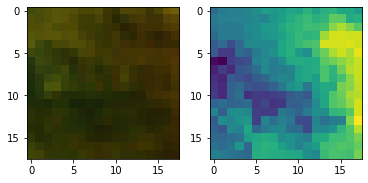

In [9]:
# We load one tile from the dataset and we display it
img = io.imread(MAIN_FOLDER+'agia_napa/img/s2/img_409.tif')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img[:, :, :]/norm_param)

# We load the ground truth
gt = io.imread(MAIN_FOLDER+'agia_napa/depth/s2/depth_409.tif')
fig.add_subplot(122)
plt.imshow(gt/norm_param_depth)
print(gt/norm_param_depth)

plt.show()

We need to define a bunch of utils functions.

In [10]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w)
    x2 = x1 + w
    y1 = random.randint(0, H - h)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, reduction=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, reduction='mean')
##        return nn.CrossEntropyLoss(output, target,weight)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, reduction='mean')
##        return nn.CrossEntropyLoss(output, target,weight)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

#def accuracy(input, target):
#    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts):
    # Calculate RMSE, MAE, and collect predictions and targets
    rmse = np.sqrt(np.mean((predictions - gts) ** 2))
    mae = np.mean(np.abs(predictions - gts))
    std_dev = np.std(predictions - gts)
    
    print("RMSE : {:.3f}m".format(rmse*-norm_param_depth))
    print("MAE : {:.3f}m".format(mae*-norm_param_depth))
    print("Std_Dev : {:.3f}m".format(std_dev*-norm_param_depth))
    print("---")
    
    return rmse

def read_geotiff(filename, b):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(b)
    arr = band.ReadAsArray()
    return arr, ds

def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)


# Loading the dataset

We define a PyTorch dataset (`torch.utils.data.Dataset)` that loads all the tiles in memory and performs random sampling. Tiles are stored in memory on the fly.

The dataset also performs random data augmentation (horizontal and vertical flips) and normalizes the data in [0, 1].

In [11]:
# Dataset class


random.seed(1)
        
class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]
        
        

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        
        # Pick a random image
        
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/norm_param * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = 1/norm_param_depth * np.asarray(io.imread(self.label_files[random_idx]), dtype='float32')
            if self.cache:
                self.label_cache_[random_idx] = label
        

        
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        #to be fixed, only for spot6
        label_p = label[x1:x2,y1:y2]


        data_p, label_p = self.data_augmentation(data_p, label_p)

        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))
        
        

# Network definition 

We can now instantiate the network using the specified parameters. By default, the weights will be initialized using the [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) (i.e. zero-mean Gaussian distribution whose standard deviation is `√(2/n) `for a layer with `n` response connections and `b=0`).


Then, we load the network on GPU.


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.init()
net = net.to(device)

True


# Loading the data

We now create a train/test split. If you want to use another dataset, you have to adjust the method to collect all filenames. In our case, we specify a fixed train/test split for the demo.


In [13]:


# Load the datasets
all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]
# Random tile numbers for train/test split
train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
test_ids = list(set(all_ids) - set(train_ids))

train_ids = train_images
test_ids = test_images

print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['409', '418', '350', '399', '361', '430', '380', '359', '371', '377', '379', '360', '368', '419', '389', '420', '401', '408', '352', '388', '362', '421', '412', '351', '349', '390', '400', '378']
Tiles for testing :  ['411', '387', '410', '398', '370', '369', '397']



# Designing the optimizer

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the `torch.optim.lr_scheduler` to reduce the learning rate by 10 after 25, 35 and 45 epochs.


In [14]:
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr}]  ###############################################        params += [{'params':[value],'lr': base_lr / 2}]  

optimizer = optim.Adam(net.parameters(), lr=base_lr)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [5], gamma=0.1)

In [15]:
  

def test(net, test_ids, all=True):
    # Use the network on the test set
    test_images = [1 / norm_param * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids]
    test_labels = [1 / norm_param_depth * np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='float32') for id in test_ids]
    eroded_labels = [1 / norm_param_depth * np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='float32') for id in test_ids]
    all_preds = []
    all_gts = []
    all_predsm = []
    all_gtsm = []


    # Switch the network to inference mode
    net.eval()
    
    mse = None
 
    ratio = 14.222222222#8.533333333   #1 for aerial with load size 720 and crop 512
    
    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        img = scipy.ndimage.zoom(img, (ratio, ratio, 1), order=1)
        gt = scipy.ndimage.zoom(gt, (ratio, ratio), order=1)
        gt_e = scipy.ndimage.zoom(gt_e, (ratio, ratio), order=1)
        
        

        # Convert image to tensor
        img_tensor = np.copy(img).transpose((2, 0, 1))
        img_tensor = np.expand_dims(img_tensor, axis=0)
        img_tensor = torch.from_numpy(img_tensor).cuda()

        # Do the inference on the whole image
        with torch.no_grad():
            outs = net(img_tensor)
            pred = outs.data.cpu().numpy().squeeze()

        # Display the result (or handle as needed)
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1, 3, 1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1, 3, 2)
        plt.imshow(pred)  # Choosing a colormap for continuous values
        fig.add_subplot(1, 3, 3)
        plt.imshow(gt)
        plt.show()

                # Apply mask to the ground truth data
        #mask = (gt_e != 0).astype(np.float32)  # Modify the condition based on your annotation criteria
        #mask = (img[:,:,0] != 0).astype(np.float32)
        masked_pred = pred 
        masked_gt_e = gt_e 
        
        #remove 30-pixel border from the prediction
        r = 9 #2 pixels for aerial, 9 for SPOT6
        predmetrics = masked_pred[r:-r, r:-r]
        gt_emetrics = masked_gt_e[r:-r, r:-r]
        
        all_preds.append(pred)
        all_gts.append(gt_e)
        
        all_predsm.append(predmetrics)
        all_gtsm.append(gt_emetrics)

        clear_output()

        metrics(predmetrics.ravel(), gt_emetrics.ravel())
        # print(f"RSME: {rmse*-norm_param_depth}")
        rmse = metrics(np.concatenate([p.ravel() for p in all_predsm]), np.concatenate([p.ravel() for p in all_gtsm]).ravel())

    # Returning all predictions and ground truths if 'all' is set to True
    if all:
        return rmse, all_preds, all_gts
    else:
        return rmse  # Returning the final MSE for the test set


# Training the network

Let's train the network for 1 epoch to see how it works (back at work, better train for 50 epochs). The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. It might takes a few minutes on GPUs in the cloud.

If using the notebook on your own machine with the full 50 epochs, depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).


In [16]:

   

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, output, depth, mask):
        # Mask out areas with no annotations
        mse_loss = nn.MSELoss(reduction='none')

        loss = mse_loss(output, depth)
        loss = (loss * mask.float()).sum() # gives \sigma_euclidean over unmasked elements

        non_zero_elements = mask.sum()
        mse_loss_val = torch.sqrt(loss / non_zero_elements)


        return mse_loss_val

def train(net, optimizer, epochs, scheduler=None, save_epoch = 5):
    global epoch_folder
    global data_folder
    losses = np.zeros(10000000)
    mean_losses = np.zeros(100000000)
    mean_rmse_plot = np.zeros(1000000)
    mean_mse_plot = np.zeros(1000000)
    rmse_plot = np.zeros(1000000)
    mse_plot = np.zeros(1000000)

    epoch_folder = '/home/pagraf/Desktop/magicbathy/'

    criterion = CustomLoss()
    iter_ = 0
    
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.to(device)), Variable(target.to(device))
            optimizer.zero_grad()

            
            size=(300, 300)
            
            # Resizing data_p and label_p
            data = F.interpolate(data, size=size, mode='nearest')
            target = F.interpolate(target.unsqueeze(0), size=size, mode='nearest')
            
            #print(data.shape)
            #print(target.shape)

            
            
            crop_size =256
            data_size = data.size()[2:]  # Get the original data size

            if data_size[0] > crop_size and data_size[1] > crop_size:
                    # Use RandomCrop transformation for data and target
                data_transform = RandomCrop(size=crop_size)
                target_transform = RandomCrop(size=crop_size)
    
                    # Apply RandomCrop transformation to data and target
                data = data_transform(data)
                target = target_transform(target)
                
            # Generate mask for non-annotated pixels in depth data (example: identify pixels with value 0)
            mask = (target.cpu().numpy() > 0).astype(np.float32)  # Modify this condition based on your annotation criteria
            mask = torch.from_numpy(mask)  # Convert the modified NumPy array back to PyTorch tensor if needed
            mask = mask.reshape(crop_size, crop_size)
            mask = mask.to(device)  # Move tensor to device (GPU, if available)

            output = net(data)

            loss = criterion(output, target, mask)
            
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.item() ##loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            pred = output.data.cpu().numpy()[0]
            gt = target.data.cpu().numpy()[0]
            
                # Apply the mask to the predictions and ground truth
            masked_pred = pred * mask.cpu().numpy()
            masked_gt = gt * mask.cpu().numpy()

            
            #print(gt)

            rmse_plot[iter_] = metrics(np.concatenate([p.ravel() for p in masked_pred]), np.concatenate([p.ravel() for p in masked_gt]).ravel())
            mean_rmse_plot[iter_] = np.mean(rmse_plot[max(0,iter_-100):iter_])
            
            
            if iter_ % 100 == 0:
                if iter_ % 1000 == 0 and iter_ != 0:
                    try:
                        os.mkdir(DATA_FOLDER)
                    except FileExistsError:
                        pass
                clear_output()
                rgb = np.asarray(np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='float32')
                pred = output.data.cpu().numpy()[0]
                gt = target.data.cpu().numpy()[0]
                masked_pred = pred * mask.cpu().numpy()
                masked_gt = gt * mask.cpu().numpy()

                
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\Mean RMSE in m: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), -norm_param_depth * metrics(np.concatenate([p.ravel() for p in masked_pred]), np.concatenate([p.ravel() for p in masked_gt]).ravel()))) ##loss.data[0]
                # plt.plot(mean_losses[:iter_]) and plt.show() 
                fig1 = plt.figure(figsize=(14.0, 8.0))
                #plt.plot(losses[:iter_], 'red')
                plt.plot(mean_losses[:iter_], 'blue')
                plt.plot(-norm_param_depth * mean_rmse_plot[:iter_], 'red')
                
                plt.title('Training Loss and RMSE in m')
                #plt.ylabelright('Accuracy')
                #plt.ylabelleft('Loss')
                plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
                plt.xlabel('Iteration')
                plt.grid(color='black', linestyle='-', linewidth=0.5)
                lgd = plt.legend([ 'Mean loss', 'RMSE in m'], loc='center left', bbox_to_anchor=(0.5, -0.02))
                plt.show()
                if iter_ % 1000 == 0 and iter_ != 0:
                    # plt.savefig(MAIN_FOLDER + model_folder +"output_data_filled_irfanview_no_shades_10/diagram_{}_out_of_{}".format(e,epochs))
                    fig1.savefig(DATA_FOLDER + "/train_metrics_{}_out_of_{}".format(e, epochs), bbox_extra_artists=lgd)
                    # plt.savefig("Train_epoch_{}/{}_{}/{}_({:.0f}%).png".format(e, epochs, batch_idx, len(train_loader), 100. * batch_idx / len(train_loader)))
                fig = plt.figure(figsize=(14.0, 8.0))
                
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                
                fig.add_subplot(132)
                plt.imshow(gt[0,:,:], cmap='viridis_r', vmin=0, vmax=1)
                
                plt.title('Ground truth')
                
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(pred[0,:,:],  cmap='viridis_r', vmin=0, vmax=1)
                
                plt.suptitle('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\nLoss: {:.6f}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item()))
                plt.show()
                
     

                if iter_ % 1000 == 0 and iter_ != 0:
                    # plt.savefig(MAIN_FOLDER + model_folder +"output_data_filled_irfanview_no_shades_10/diagram_{}_out_of_{}".format(e,epochs))
                    fig.savefig(DATA_FOLDER + "/train_images_{}_out_of_{}".format(e, epochs))
                    # plt.savefig("Train_epoch_{}/{}_{}/{}_({:.0f}%).png".format(e, epochs, batch_idx, len(train_loader), 100. * batch_idx / len(train_loader)))
            iter_ += 1
            
            del(data, target, loss)      
            
        if e % save_epoch == 0:
            try:
                os.mkdir(epoch_folder)
            except FileExistsError:
                pass
            

            # We validate with the largest possible stride for faster computing
            acc = test(net, test_ids, all=False)
            torch.save(net.state_dict(),epoch_folder + 'model_epoch{}'.format(e))
    torch.save(net.state_dict(), epoch_folder + 'model_final')

In [17]:
train(net, optimizer, 10, scheduler)

RMSE : 0.557m
MAE : 0.491m
Std_Dev : 0.360m
---
RMSE : 0.683m
MAE : 0.477m
Std_Dev : 0.595m
---



# Testing the network

Now that the training has ended, we can load the final weights and test the network using a reasonable stride, e.g. half or a quarter of the window size. Inference time depends on the chosen stride, e.g. a step size of 32 (75% overlap) will take 10 secondes / image.


In [18]:
net.load_state_dict(torch.load('./model_final'))

<All keys matched successfully>

In [19]:
_, all_preds, all_gts= test(net, test_ids, all=True)
#print(all_preds)
#print(all_gts)

RMSE : 0.557m
MAE : 0.491m
Std_Dev : 0.360m
---
RMSE : 0.683m
MAE : 0.477m
Std_Dev : 0.595m
---



# Saving the results

We can visualize and save the resulting tiles for qualitative assessment.


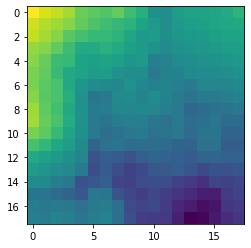

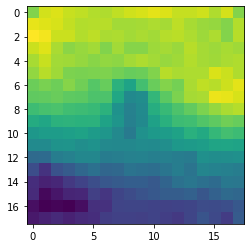

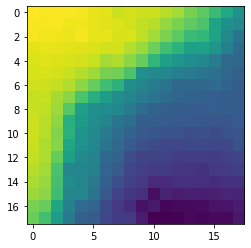

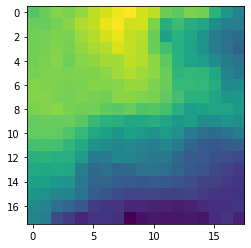

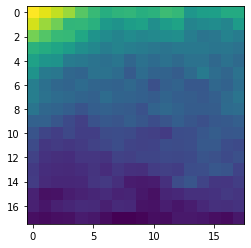

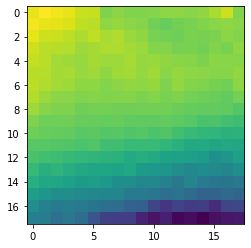

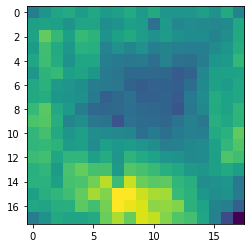

In [21]:
ratio = 14.222222222

for p, id_ in zip(all_preds, test_ids):
    img = p*norm_param_depth
    
    img = scipy.ndimage.zoom(img, (1/ratio, 1/ratio), order=1)
    
    #print(img)
    plt.imshow(img, cmap='viridis') and plt.show()

    #io.imsave('/home/pagraf/Desktop/magicbathy/inference_tile_{}.png'.format(id_), img)
    nlcd02_arr_1, nlcd02_ds_1 = read_geotiff(MAIN_FOLDER + 'puck_laggon/img/s2/img_410.tif', 3)
    write_geotiff('./inference_tile_{}.tif'.format(id_), img, nlcd02_ds_1)

pandas==1.4.1
numpy==1.22.1
